<h2>Forecasting The Number Of People Infected With Coronavirus in the World</h2>

Source: https://www.kaggle.com/kiranbhonsle/forecasting-covid-19-infected-people-in-world

<h3>Importing necessary libraries</h3>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from datetime import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [0]:
#Cloning data from GitHub.
!git clone https://github.com/CSSEGISandData/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 17088 (delta 0), reused 2 (delta 0), pack-reused 17082
Receiving objects: 100% (17088/17088), 66.59 MiB | 10.06 MiB/s, done.
Resolving deltas: 100% (8562/8562), done.


In [0]:
cor_inf = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
cor_inf.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7


<h3>Data Preprocessing for the covid-19 dataset</h3>

<p>The valuable features what we are hunting for is <li>Country names.</li><li>Count of
    infected people</li><li> Dates</li> </br>At which they were affected in the country.
    As we are not focused on predicting on indiviual country as it might be 
    bias on some country as a result the prediction might be very large or too small
    which may be act as outlier.</p>

In [0]:
#drop lat long and province/state columns
cor_inf.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20'],
      dtype='object')

<p> Drop the <b>Province/State</b>,<b> Latitude</b> and <b> Longitude</b> columns  as they make the data to narrow and data for those column might be missing for some countries </p>

In [0]:
cor_inf.drop(labels = ['Province/State','Lat', 'Long'],axis = 1, inplace= True)

In [0]:
cor_inf.head(100)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170
1,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223
2,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584
3,Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370
4,Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Djibouti,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,3,3,11,11,12,14,18,18
96,Dominican Republic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,5,5,5,5,5,5,11,11,11,21,21,34,72,112,202,245,312,392,488,581,719,859,901
97,Ecuador,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,7,10,13,13,13,14,15,15,17,17,17,28,28,37,58,111,199,367,506,789,981,1082,1173,1403,1595,1823,1924,1962
98,Egypt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,3,15,15,49,55,59,60,67,80,109,110,150,196,196,256,285,294,327,366,402,456,495,536,576,609,656


<h3>Reshaping the data to proceed with Forecasting</h3>

<p>Now we want to reshape the data as per the requirement i.e make index as dates,and column
name as country names
</p>

In [0]:
cor_inf.shape

(254, 70)

In [0]:
new = cor_inf['Country/Region']

In [0]:
new

0         Afghanistan
1             Albania
2             Algeria
3             Andorra
4              Angola
            ...      
249    United Kingdom
250    United Kingdom
251    United Kingdom
252        MS Zaandam
253          Botswana
Name: Country/Region, Length: 254, dtype: object

<p>To get the total infected people per day in the world we sum the count of infected people from all the countries and group them as per dates</p>
<p>But before we saw that in the country/Region column we have duplicated data as a result
we need to first sum all the country and then get the count of all the people infected </p>

In [0]:
#group by data based upon country since the countries name are repeated more than once 
cor_inf = cor_inf.groupby(['Country/Region']).sum()

In [0]:
cor_inf

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,17,33,36,42,42,70,70,77,84,91,107,107,119,119,135
Vietnam,0,2,2,2,2,2,2,2,2,2,6,6,8,8,8,10,10,13,13,14,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,18,30,30,31,38,39,47,53,56,61,66,75,85,91,94,113,123,134,141,153,163,174,188,203
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,16,16,19,26,30,30,31,35,38,38,39,41,44,47,48,52,59,59,59,84,91,98,109,116


In [0]:
#reshape the data as per the time series analysis
cor_inf_re = pd.DataFrame()
for i in range(0,len(cor_inf)):
    cor_inf_re[cor_inf.index[i]] = cor_inf.iloc[i].values
    

In [0]:
type(cor_inf.index[0])

str

In [0]:
cor_inf_re.index = cor_inf.columns[:]

In [0]:
cor_inf_re.head(5)


,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,...,Saint Kitts and Nevis,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
1/22/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,643,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,920,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,5,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1406,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,7,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0
1/26/20,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2075,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,4,0,8,0,0,0,0,0,5,0,0,0,0,0,0,0,2,0,0,0


In [0]:
def total_infected_sum():
    count = []
    for i in range(0,len(cor_inf_re)):
        count.append(sum(cor_inf_re.iloc[i].values))
    return count

In [0]:
cor_inf_re['Total infected'] = total_infected_sum()

In [0]:
cor_inf_re.tail(5)

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,...,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe,Total infected
3/26/20,94,174,367,224,4,7,502,290,2810,6909,122,9,458,44,18,86,6235,2,6,2,43,191,0,2985,114,264,152,0,4,96,75,4042,3,3,1306,81782,491,4,51,231,...,3,1,208,1012,105,384,7,683,226,562,2,927,57786,106,3,8,2840,11811,5,252,13,1045,1,23,65,197,3629,83836,14,196,333,11812,217,75,107,153,84,16,3,529591
3/27/20,110,186,409,267,4,7,589,329,3143,7657,165,10,466,48,24,94,7284,2,6,3,61,237,0,3417,115,293,180,8,5,99,91,4682,3,3,1610,81897,539,4,51,263,...,3,1,223,1104,119,457,7,732,269,632,3,1170,65719,106,3,8,3069,12928,5,267,13,1136,1,25,66,227,5698,101657,23,310,405,14745,238,88,107,163,91,22,5,593291
3/28/20,110,197,454,308,5,7,690,407,3640,8271,182,10,476,48,26,94,9134,2,6,3,74,258,0,3904,120,331,207,8,5,99,91,5576,3,3,1909,81999,608,4,65,295,...,3,1,224,1203,130,659,8,802,292,684,3,1187,73235,113,5,8,3447,14076,5,283,14,1245,1,25,74,278,7402,121478,30,356,468,17312,274,104,119,174,98,28,7,660706
3/29/20,120,212,511,334,7,7,745,424,3984,8788,209,11,499,48,33,94,10836,2,6,4,81,323,0,4256,126,346,222,10,6,103,139,6280,3,3,2139,82122,702,19,65,314,...,9,1,224,1299,142,741,8,844,314,730,3,1280,80110,117,6,8,3700,14829,9,298,14,1388,1,25,78,312,9217,140886,33,475,570,19780,304,144,119,188,109,29,7,720117
3/30/20,170,223,584,370,7,7,820,482,4361,9618,273,14,515,49,33,152,11899,3,6,4,97,368,3,4579,127,359,246,14,6,107,139,7398,3,5,2449,82198,798,19,81,330,...,9,1,230,1453,162,785,8,879,336,756,3,1326,87956,122,6,8,4028,15922,10,306,19,1524,1,30,82,312,10827,161807,33,548,611,22453,310,149,135,203,116,35,7,782365


In [0]:
total = cor_inf_re.loc[:, :]

In [0]:
total.head()

In [0]:
daily = total.diff()

In [0]:
daily.fillna(0, inplace = True)
daily.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,...,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe,Total infected
1/22/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,99.0
1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,277.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0
1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,486.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,493.0
1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,669.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,684.0


In [0]:
total.fillna(0, inplace = True)
total.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,...,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe,Total infected
1/22/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,555
1/23/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,643,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,654
1/24/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,920,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,5,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,941
1/25/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1406,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,7,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,1434
1/26/20,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2075,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,4,0,8,0,0,0,0,0,5,0,0,0,0,0,0,0,2,0,0,0,2118


<p>Now only we need to convert index datatype i.e object to datetime </p>

In [0]:
def parser(date):
    date = datetime.strptime(date,'%m/%d/%y')
    date  = str(date.day) + '-' + str(date.month) + '-' + str(date.year)
    print(date)
    return datetime.strptime(date,'%d-%m-%Y')

In [0]:
#convert str to datetime in index 
timestamp = []
for i in range(0,len(cor_inf_re)):
    timestamp.append(parser(cor_inf_re.index[i]))
cor_inf_re.index = timestamp

22-1-2020
23-1-2020
24-1-2020
25-1-2020
26-1-2020
27-1-2020
28-1-2020
29-1-2020
30-1-2020
31-1-2020
1-2-2020
2-2-2020
3-2-2020
4-2-2020
5-2-2020
6-2-2020
7-2-2020
8-2-2020
9-2-2020
10-2-2020
11-2-2020
12-2-2020
13-2-2020
14-2-2020
15-2-2020
16-2-2020
17-2-2020
18-2-2020
19-2-2020
20-2-2020
21-2-2020
22-2-2020
23-2-2020
24-2-2020
25-2-2020
26-2-2020
27-2-2020
28-2-2020
29-2-2020
1-3-2020
2-3-2020
3-3-2020
4-3-2020
5-3-2020
6-3-2020
7-3-2020
8-3-2020
9-3-2020
10-3-2020
11-3-2020
12-3-2020
13-3-2020
14-3-2020
15-3-2020
16-3-2020
17-3-2020
18-3-2020
19-3-2020
20-3-2020
21-3-2020
22-3-2020
23-3-2020
24-3-2020
25-3-2020
26-3-2020
27-3-2020
28-3-2020
29-3-2020
30-3-2020


<b>Sum all the count of infected people of each country to get the total infected people per date
</b>

In [0]:
cor_inf_re.to_csv('covid_19_confirmed.csv')

In [0]:
#preparing for time series
infected_people = cor_inf_re['Total infected']

In [0]:
#column for infected per day
diff = []
diff.append(cor_inf_re['Total infected'][0])
for i in range(0,len(cor_inf_re['Total infected']) - 1):
    diff.append(cor_inf_re['Total infected'][i+1] - cor_inf_re['Total infected'][i])

cor_inf_re['Infected_per_Day'] = diff

<h3>Visualization of dataset</h3>

In [0]:
infected_people

2020-01-22       555
2020-01-23       654
2020-01-24       941
2020-01-25      1434
2020-01-26      2118
               ...  
2020-03-26    529591
2020-03-27    593291
2020-03-28    660706
2020-03-29    720117
2020-03-30    782365
Name: Total infected, Length: 69, dtype: int64

In [0]:
#check the statistical part of the data
infected_people.describe()

count        69.000000
mean     141259.246377
std      177353.519351
min         555.000000
25%       37120.000000
50%       80406.000000
75%      145205.000000
max      782365.000000
Name: Total infected, dtype: float64

In [0]:
#to check if there is an trend or seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(infected_people)

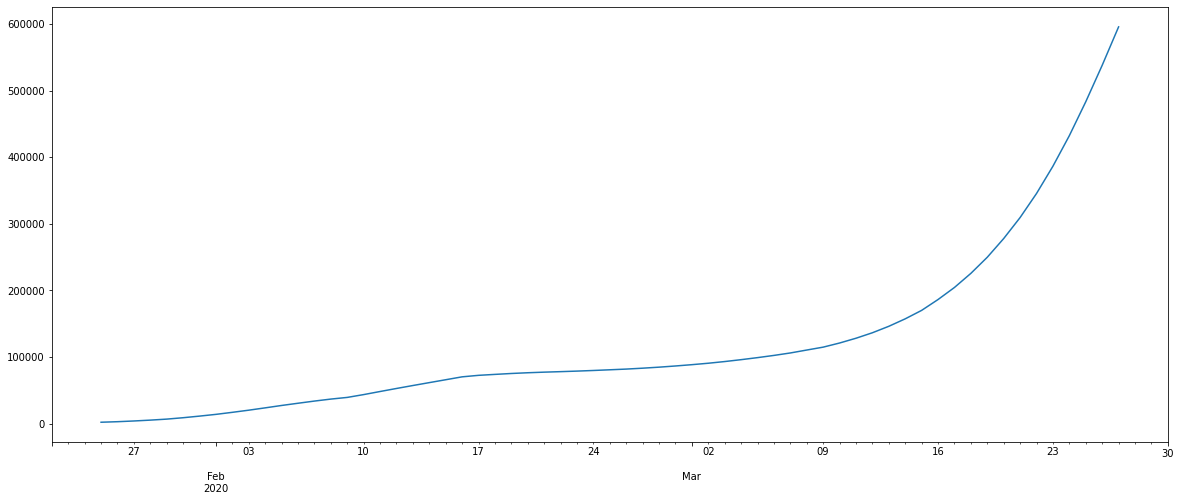

In [0]:
result.trend.plot(figsize=(20,8))

In [0]:
train = infected_people.iloc[:]
test = infected_people.iloc[:]
#train.replace(0,1, inplace = True)
train.tail()

2020-03-26    529591
2020-03-27    593291
2020-03-28    660706
2020-03-29    720117
2020-03-30    782365
Name: Total infected, dtype: int64

<h2>Exponential Smoothing</h2>

Single, Double and Triple Exponential Smoothing can be implemented in Python using the ExponentialSmoothing Statsmodels class.

First, an instance of the ExponentialSmoothing class must be instantiated, specifying both the training data and some configuration for the model.

Specifically, you must specify the following configuration parameters:

<li>trend: The type of trend component, as either “add” for additive or “mul” for multiplicative. Modeling the trend can be disabled by setting it to None.</li>
<li>damped: Whether or not the trend component should be damped, either True or False.</li>
<li>seasonal: The type of seasonal component, as either “add” for additive or “mul” for multiplicative. Modeling the seasonal component can be disabled by setting it to None.</li>
<li>seasonal_periods: The number of time steps in a seasonal period, e.g. 12 for 12 months in a yearly seasonal structure (more here).
</li>

The model can then be fit on the training data by calling the fit() function.

This function allows you to either specify the smoothing coefficients of the exponential smoothing model or have them optimized. By default, they are optimized (e.g. optimized=True). These coefficients include:

smoothing_level (alpha): the smoothing coefficient for the level.
smoothing_slope (beta): the smoothing coefficient for the trend.
smoothing_seasonal (gamma): the smoothing coefficient for the seasonal component.
damping_slope (phi): the coefficient for the damped trend.

In [0]:
model1 = ExponentialSmoothing(train,trend = "mul",seasonal_periods=2,seasonal="add").fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [0]:
predictions1 = model1.predict(start = 65 ,end= 80 )
pd.options.display.float_format = '{:,.0f}'.format
predictions1

2020-03-27     599,625
2020-03-28     660,865
2020-03-29     736,873
2020-03-30     782,536
2020-03-31     851,641
2020-04-01     923,550
2020-04-02   1,003,185
2020-04-03   1,086,213
2020-04-04   1,177,782
2020-04-05   1,273,621
2020-04-06   1,378,940
2020-04-07   1,489,538
2020-04-08   1,610,699
2020-04-09   1,738,301
2020-04-10   1,877,714
2020-04-11   2,024,907
Freq: D, dtype: float64

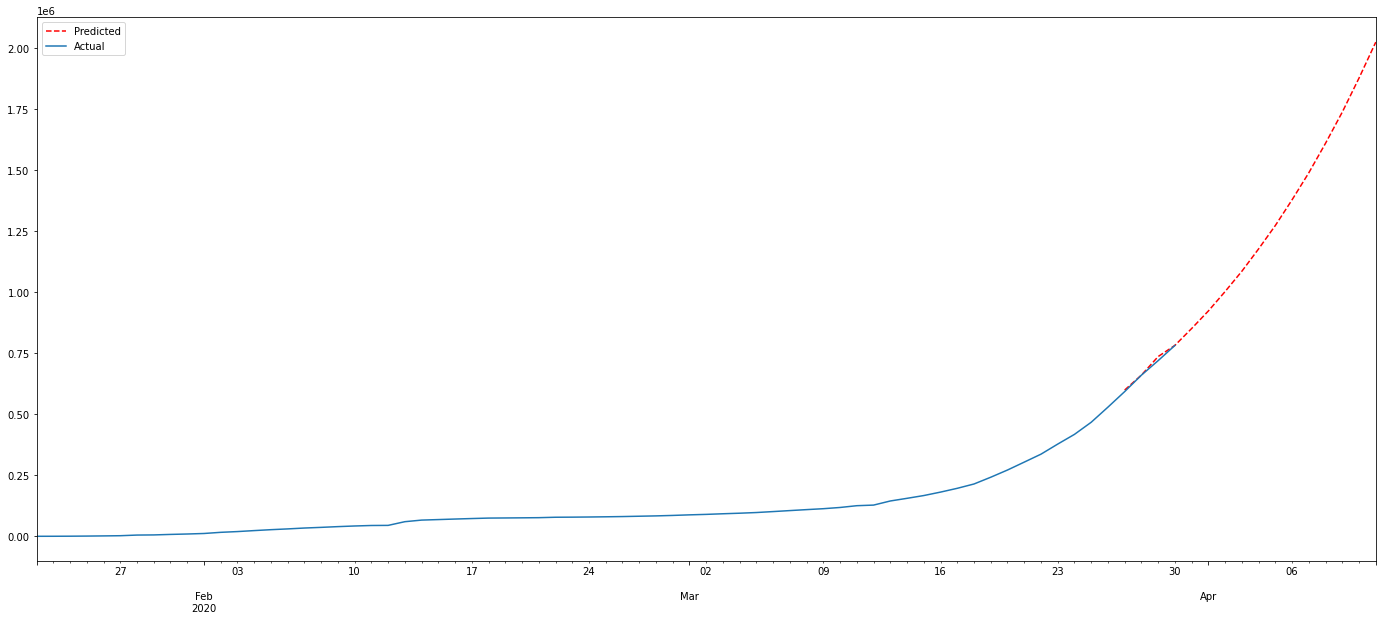

In [0]:
plt.figure(figsize = (24,10))
predictions1.plot(c ='r',linestyle='--', label =  "Predicted")
test.plot(linestyle='-', label = "Actual")
plt.legend(loc = "upper left")

<h2>SARIMAX model</h2>

In [0]:
model2 = SARIMAX(train,order = (4,2,1),trend='t',seasonal_order=(2, 2, 1, 12))
model_fit = model2.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [0]:
predictions2 = model_fit.predict(start = 65,end=80)
pd.options.display.float_format = '{:,.0f}'.format
predictions2

2020-03-27     589,452
2020-03-28     658,731
2020-03-29     730,558
2020-03-30     788,729
2020-03-31     858,467
2020-04-01     934,952
2020-04-02   1,017,183
2020-04-03   1,103,806
2020-04-04   1,201,129
2020-04-05   1,297,143
2020-04-06   1,411,831
2020-04-07   1,535,821
2020-04-08   1,664,094
2020-04-09   1,799,386
2020-04-10   1,931,444
2020-04-11   2,070,171
Freq: D, dtype: float64

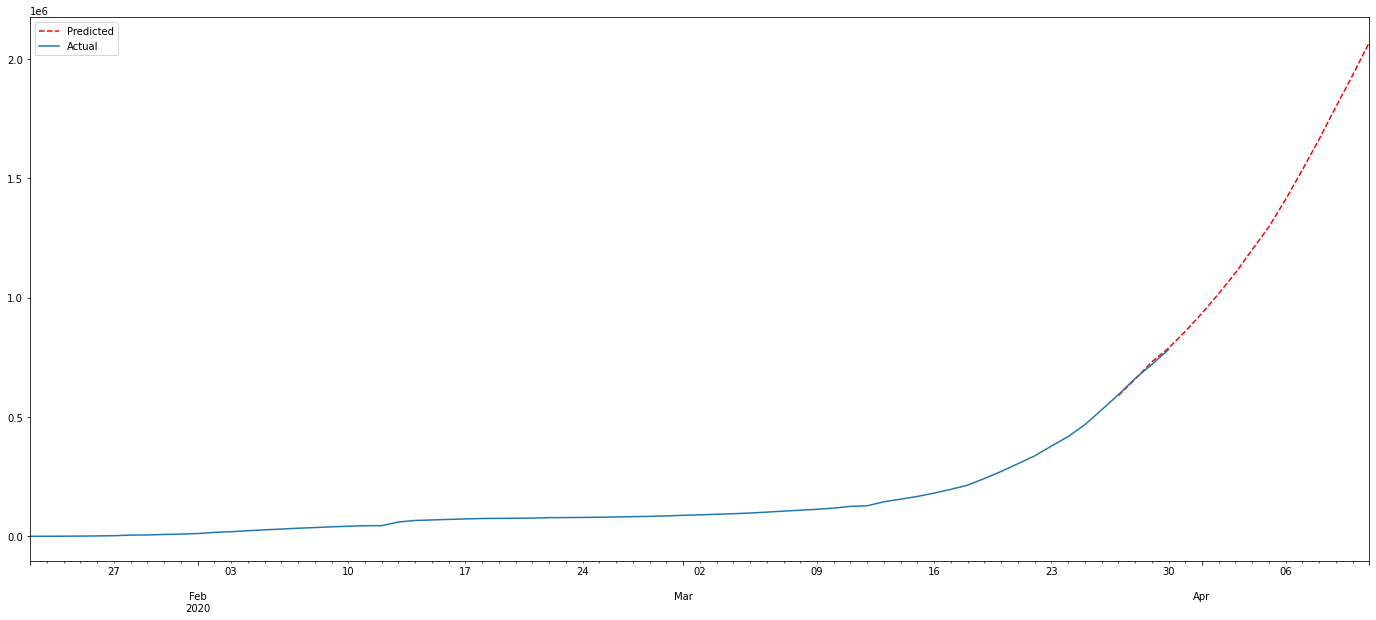

In [0]:
plt.figure(figsize = (24,10))
predictions2.plot(c ='r',linestyle='--', label =  "Predicted")
test.plot(linestyle='-', label = "Actual")
plt.legend(loc = 'upper left')

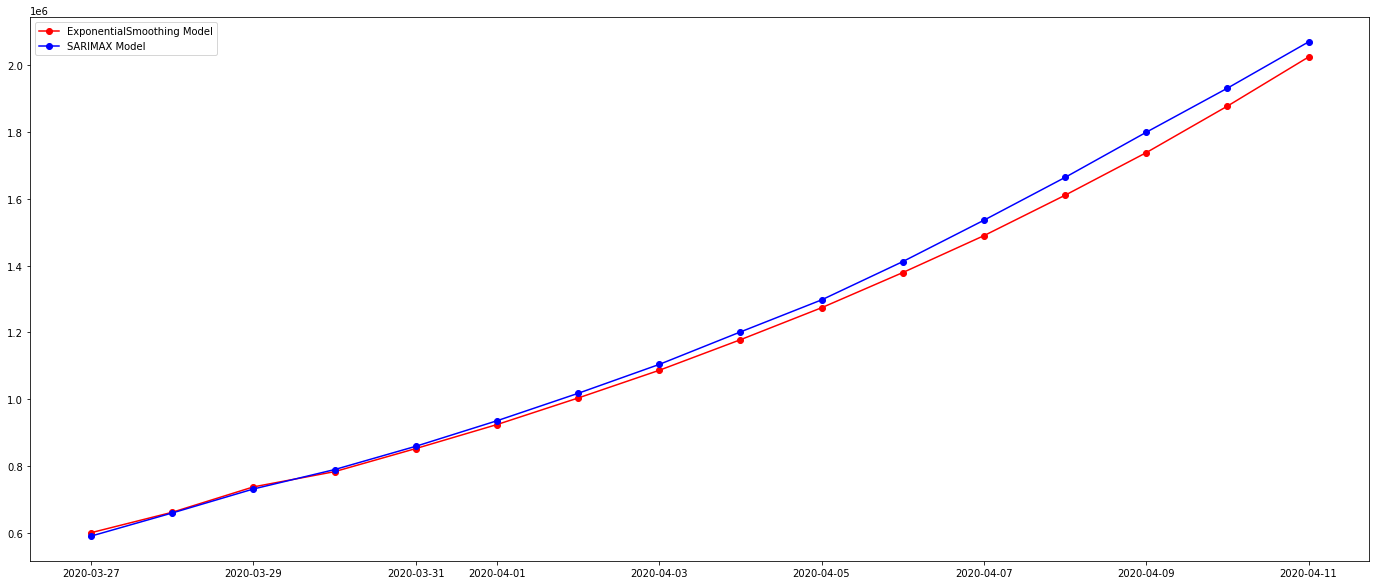

In [0]:
plt.figure(figsize = (24,10))
plt.plot(predictions1,'r',marker = 'o', label = "ExponentialSmoothing Model")
plt.plot(predictions2,'b',marker = 'o', label = "SARIMAX Model")
plt.legend()

Thus Exponential model is better than the SARIMAX Model.

As per the result it might be that after one week from now, it will affect around **1.5 Million People** all over the World!